In [9]:
import symlib
import pynumdiff
import pynumdiff.optimize
import os
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline


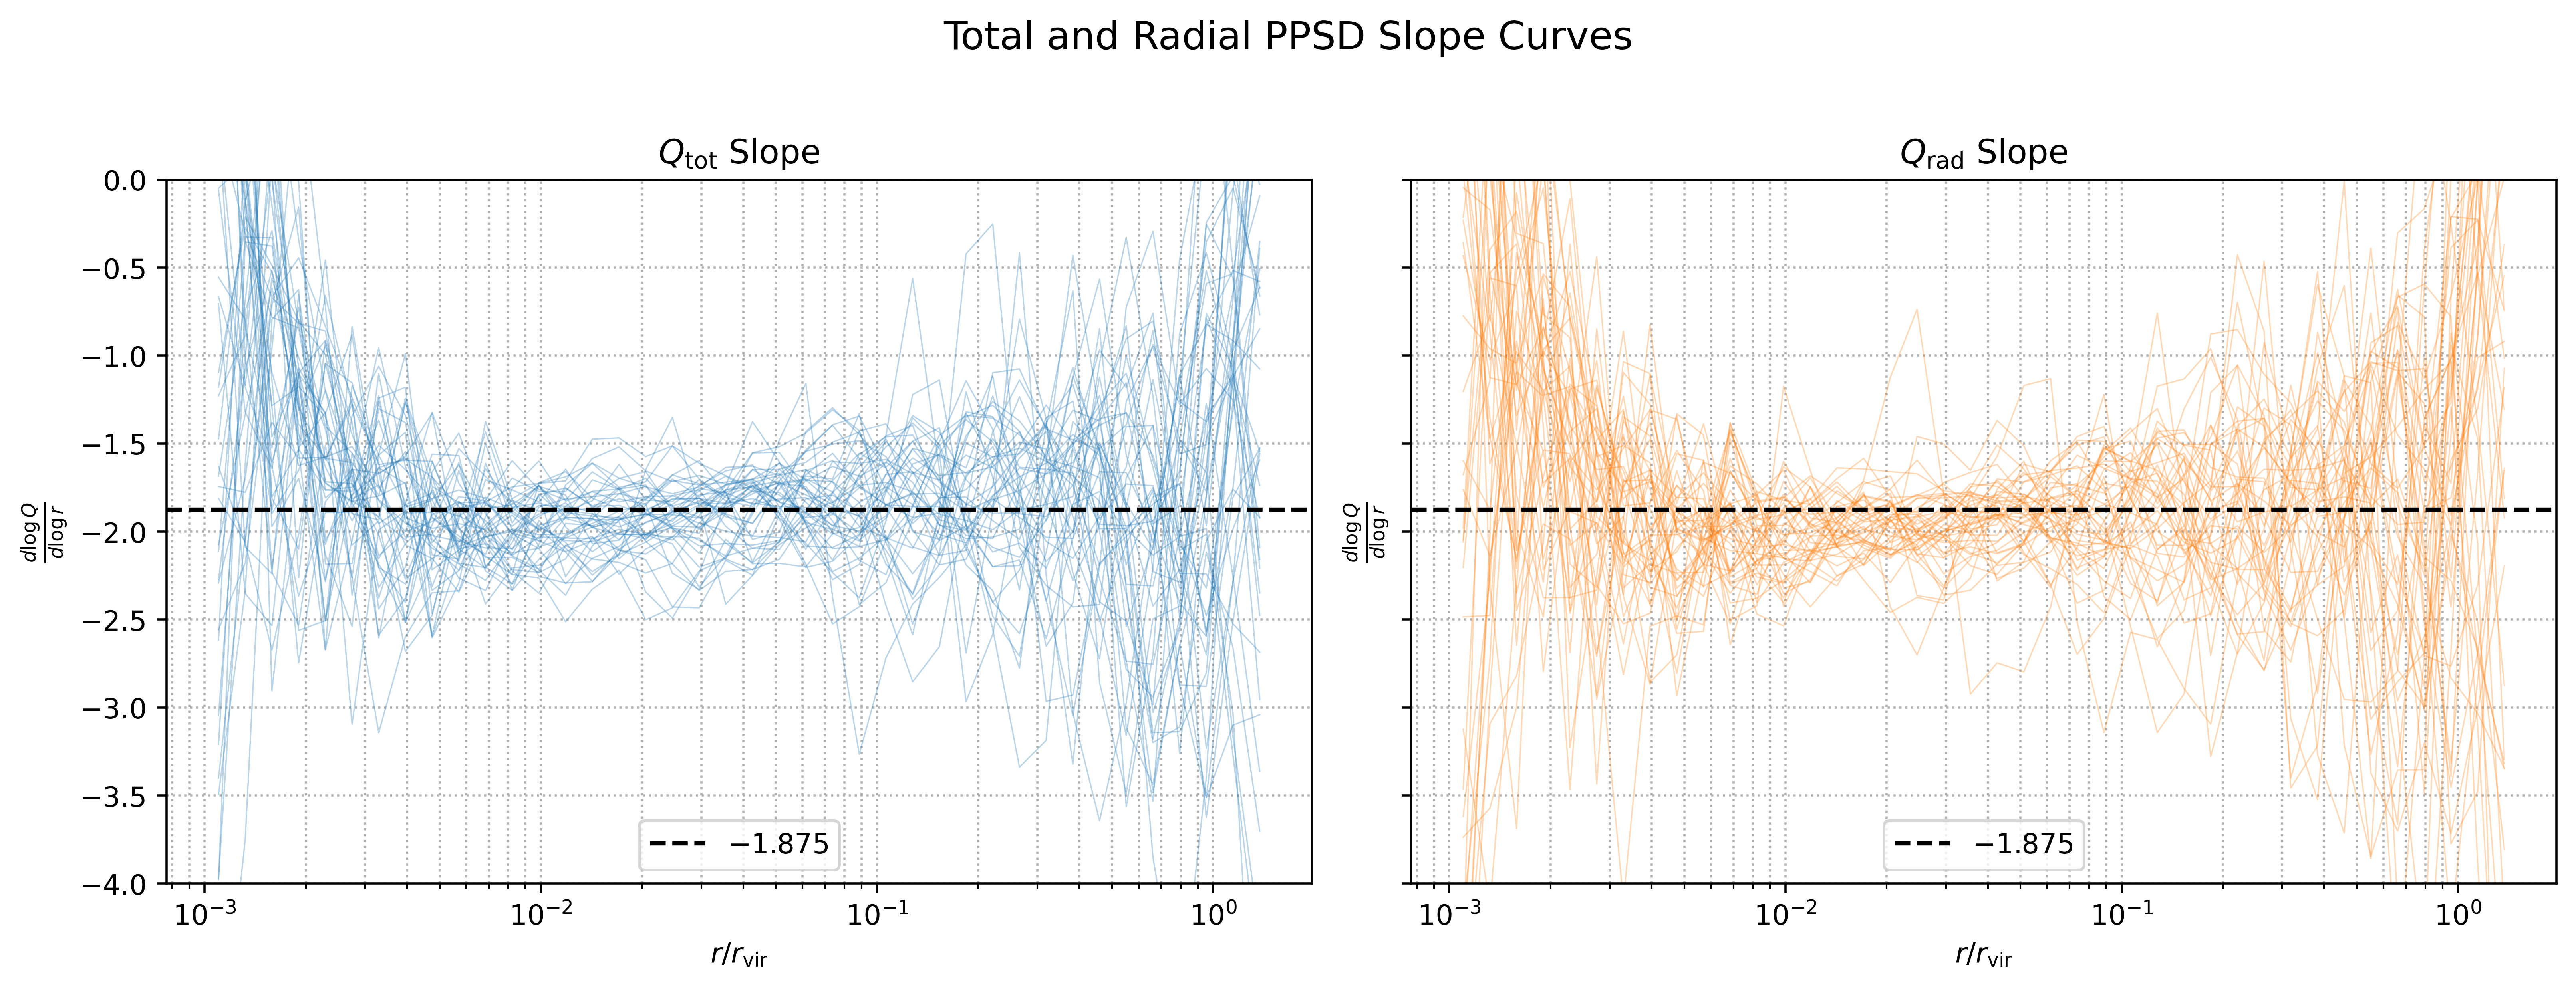

[Saved] Total and radial PPSD slope figure saved.


In [15]:
def ppsd_slopes(base_dir, suite_name, window_width=0.1):
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
    assert len(density_files) == len(velocity_files), "Mismatch in number of halos."

    fig, axes = plt.subplots(1, 2, figsize=(13, 5), dpi=500, sharex=True, sharey=True)
    ax_tot, ax_rad = axes

    for f_rho, f_vel in zip(density_files, velocity_files):
        df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
        df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))

        r = df_rho["r_scaled"].values
        rho = df_rho["rho_scaled"].values
        sigma_tot = df_vel["sigma_total_scaled"].values
        sigma_rad = df_vel["sigma_rad_scaled"].values

        # Compute total and radial PPSD
        with np.errstate(divide="ignore", invalid="ignore"):
            Q_tot = np.where(sigma_tot > 0, rho / sigma_tot**3, np.nan)
            Q_rad = np.where(sigma_rad > 0, rho / sigma_rad**3, np.nan)

        log_r = np.log10(r)
        log_Q_tot = np.log10(Q_tot)
        log_Q_rad = np.log10(Q_rad)
        slopes_tot = np.full_like(r, np.nan)
        slopes_rad = np.full_like(r, np.nan)

        for i in range(len(r)):
            log_r_i = log_r[i]
            dlogr = window_width / 2
            idx = (log_r >= log_r_i - dlogr) & (log_r <= log_r_i + dlogr)
            if np.sum(idx) >= 2:
                slope_tot, _, _, _, _ = linregress(log_r[idx], log_Q_tot[idx])
                slope_rad, _, _, _, _ = linregress(log_r[idx], log_Q_rad[idx])
                slopes_tot[i] = slope_tot
                slopes_rad[i] = slope_rad

        valid = (r > 0) & np.isfinite(slopes_tot) & np.isfinite(slopes_rad)
        if np.sum(valid) > 0:
            ax_tot.plot(r[valid], slopes_tot[valid], alpha=0.3, color="C0", lw=0.5)
            ax_rad.plot(r[valid], slopes_rad[valid], alpha=0.3, color="C1", lw=0.5)

    # Plot formatting
    for ax, label, color in zip(axes, [r"$Q_{\mathrm{tot}}$", r"$Q_{\mathrm{rad}}$"], ["C0", "C1"]):
        ax.axhline(-1.875, color='k', linestyle='--', label=r"$-1.875$")
        ax.set_xlabel(r"$r / r_{\mathrm{vir}}$")
        ax.set_xscale("log")
        ax.set_ylabel(r"$\frac{d\log Q}{d\log r}$")
        ax.set_title(f"{label} Slope")
        ax.grid(True, which="both", linestyle=":")
        ax.legend()

    ax_tot.set_ylim(-4, 0)
    ax_rad.set_ylim(-4, 0)

    fig.suptitle("Total and Radial PPSD Slope Curves", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(os.path.join(output_dir, "PPSD_slope(window).png"))
    plt.show()
    print("[Saved] Total and radial PPSD slope figure saved.")

# Example usage:
ppsd_slopes("/Volumes/Atlas/Symphony", "SymphonyMilkyWay", window_width=0.3)


In [ ]:
def ppsd_slopes(base_dir, suite_name, method='constant_jerk', tvgamma=None):
    # --- Directories ---
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    mass_dir = os.path.join(base_dir, "output", suite_name, "mass_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    # --- Files ---
    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
    mass_files = sorted([f for f in os.listdir(mass_dir) if f.endswith(".csv")])
    n_halos = len(density_files)

    # --- Concentration ---
    concentrations = []
    for i in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, i)
        try:
            r_data, _ = symlib.read_rockstar(sim_dir)
            cvir_val = r_data[0, -1]['cvir']
        except FileNotFoundError:
            print(f"[Warning] Missing Rockstar file for Halo {i}")
            cvir_val = np.nan
        concentrations.append(cvir_val)
    concentrations = np.array(concentrations)

    # --- Colormap ---
    cmap = cm.viridis
    norm = colors.Normalize(vmin=np.nanmin(concentrations), vmax=np.nanmax(concentrations))
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)

    # --- Setup Plot ---
    fig1, axes1 = plt.subplots(2, 2, figsize=(13, 10), dpi=500, sharex=True, constrained_layout=True)
    fig2, axes2 = plt.subplots(2, 2, figsize=(13, 10), dpi=500, sharex=True, constrained_layout=True)
    ax_Qtot, ax_Qrad = axes1[0]
    ax_slope_tot, ax_slope_rad = axes1[1]
    ax_Qtot_m, ax_Qrad_m = axes2[0]
    ax_slope_tot_m, ax_slope_rad_m = axes2[1]

    # --- Fit and Plot ---
    def fit_and_plot(logx, logQ, axQ, axS, label):
        dt = (logx[1:] - logx[:-1]).mean()
        if np.sum(np.isfinite(logx) & np.isfinite(logQ)) < 6:
            return

        x_valid = logx[np.isfinite(logx) & np.isfinite(logQ)]
        y_valid = logQ[np.isfinite(logx) & np.isfinite(logQ)]

        try:
            # --- Identify module and method ---
            for submod in ['linear_model', 'finite_difference', 'smooth_finite_difference', 'total_variation_regularization', 'kalman_smooth']:
                try:
                    optimize_func = getattr(getattr(pynumdiff.optimize, submod), method)
                    diff_func = getattr(getattr(pynumdiff, submod), method)
                    break
                except AttributeError:
                    continue
            else:
                print(f"[Error] Method '{method}' not found in any submodule.")
                return

            # --- Optimize Parameters ---
            kwargs = {'tvgamma': tvgamma} if 'tvgamma' in optimize_func.__code__.co_varnames else {}
            params, _ = optimize_func(y_valid, dt, **kwargs)

            # --- Apply Differentiator ---
            _, dydx = diff_func(y_valid, dt, params)

            x_val = 10**x_valid
            Q_smooth = 10**y_valid
            axQ.plot(x_val, Q_smooth, color=color, alpha=0.5, lw=0.5)
            axS.plot(x_val, dydx, color=color, alpha=0.5, lw=0.5)

        except Exception as e:
            print(f"[Warning] {method} failed for {label}: {e}")

    for i, (f_rho, f_vel, f_mass) in enumerate(zip(density_files, velocity_files, mass_files)):
        df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
        df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))
        df_mass = pd.read_csv(os.path.join(mass_dir, f_mass))

        r = df_rho["r_scaled"].values
        m = df_mass["m_scaled"].values
        rho = df_rho["rho_scaled"].values
        sigma_tot = df_vel["sigma_total_scaled"].values
        sigma_rad = df_vel["sigma_rad_scaled"].values

        with np.errstate(divide="ignore", invalid="ignore"):
            Q_tot = np.where(sigma_tot > 0, rho / sigma_tot**3, np.nan)
            Q_rad = np.where(sigma_rad > 0, rho / sigma_rad**3, np.nan)

        log_r = np.log10(r)
        log_m = np.log10(m)
        log_Q_tot = np.log10(Q_tot)
        log_Q_rad = np.log10(Q_rad)

        valid_r_tot = np.isfinite(log_r) & np.isfinite(log_Q_tot)
        valid_r_rad = np.isfinite(log_r) & np.isfinite(log_Q_rad)
        valid_m_tot = np.isfinite(log_m) & np.isfinite(log_Q_tot)
        valid_m_rad = np.isfinite(log_m) & np.isfinite(log_Q_rad)

        color = cmap(norm(concentrations[i]))

        fit_and_plot(log_r[valid_r_tot], log_Q_tot[valid_r_tot], ax_Qtot, ax_slope_tot, 'Qtot(r)')
        fit_and_plot(log_r[valid_r_rad], log_Q_rad[valid_r_rad], ax_Qrad, ax_slope_rad, 'Qrad(r)')
        fit_and_plot(log_m[valid_m_tot], log_Q_tot[valid_m_tot], ax_Qtot_m, ax_slope_tot_m, 'Qtot(m)')
        fit_and_plot(log_m[valid_m_rad], log_Q_rad[valid_m_rad], ax_Qrad_m, ax_slope_rad_m, 'Qrad(m)')

    # --- Axis Formatting ---
    for ax, label in zip([ax_Qtot, ax_Qrad], [r"$Q_{\mathrm{tot}}(r)$", r"$Q_{\mathrm{rad}}(r)$"]):
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylabel(label)
        ax.grid(True, which="both", linestyle=":")

    for ax in [ax_slope_tot, ax_slope_rad]:
        ax.axhline(-1.875, color='k', linestyle='--', label=r"$-1.875$")
        ax.set_xscale("log")
        ax.set_ylabel(r"$d\log Q / d\log r$")
        ax.grid(True, which="both", linestyle=":")
        ax.legend()

    for ax, label in zip([ax_Qtot_m, ax_Qrad_m], [r"$Q_{\mathrm{tot}}(m)$", r"$Q_{\mathrm{rad}}(m)$"]):
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylabel(label)
        ax.grid(True, which="both", linestyle=":")

    for ax in [ax_slope_tot_m, ax_slope_rad_m]:
        ax.set_xscale("log")
        ax.set_ylabel(r"$d\log Q / d\log m$")
        ax.grid(True, which="both", linestyle=":")

    ax_slope_tot.set_ylim(-4, 0)
    ax_slope_rad.set_ylim(-4, 0)
    ax_slope_tot_m.set_ylim(-4, 1)
    ax_slope_rad_m.set_ylim(-4, 1)

    # --- Save Figures ---
    method_str = method.replace("_", "-")
    fig1.suptitle(f"PPSD slopes vs Radius ({method_str}) - {suite_name}", fontsize=15)
    fig1.colorbar(sm, ax=axes1.ravel().tolist(), shrink=0.9).set_label(r"$c_{\mathrm{vir}}$")
    fig1.savefig(os.path.join(output_dir, f"PPSD_slopes_vs_r_{method}.png"))

    fig2.suptitle(f"PPSD slopes vs Mass ({method_str}) - {suite_name}", fontsize=15)
    fig2.colorbar(sm, ax=axes2.ravel().tolist(), shrink=0.9).set_label(r"$c_{\mathrm{vir}}$")
    fig2.savefig(os.path.join(output_dir, f"PPSD_slopes_vs_m_{method}.png"))

    plt.close(fig1)
    plt.close(fig2)
    print(f"[Saved] pynumdiff-based slope figures (method = {method})")


In [ ]:
def run_all_pynumdiff_methods(base_dir, suite_name):
    methods = [
        "constant_jerk"
    ]
    for method in methods:
        print(f"\n--- Running {method} ---")
        ppsd_slopes(base_dir, suite_name, method=method)

run_all_pynumdiff_methods("/Volumes/Atlas/Symphony", "SymphonyLMC")

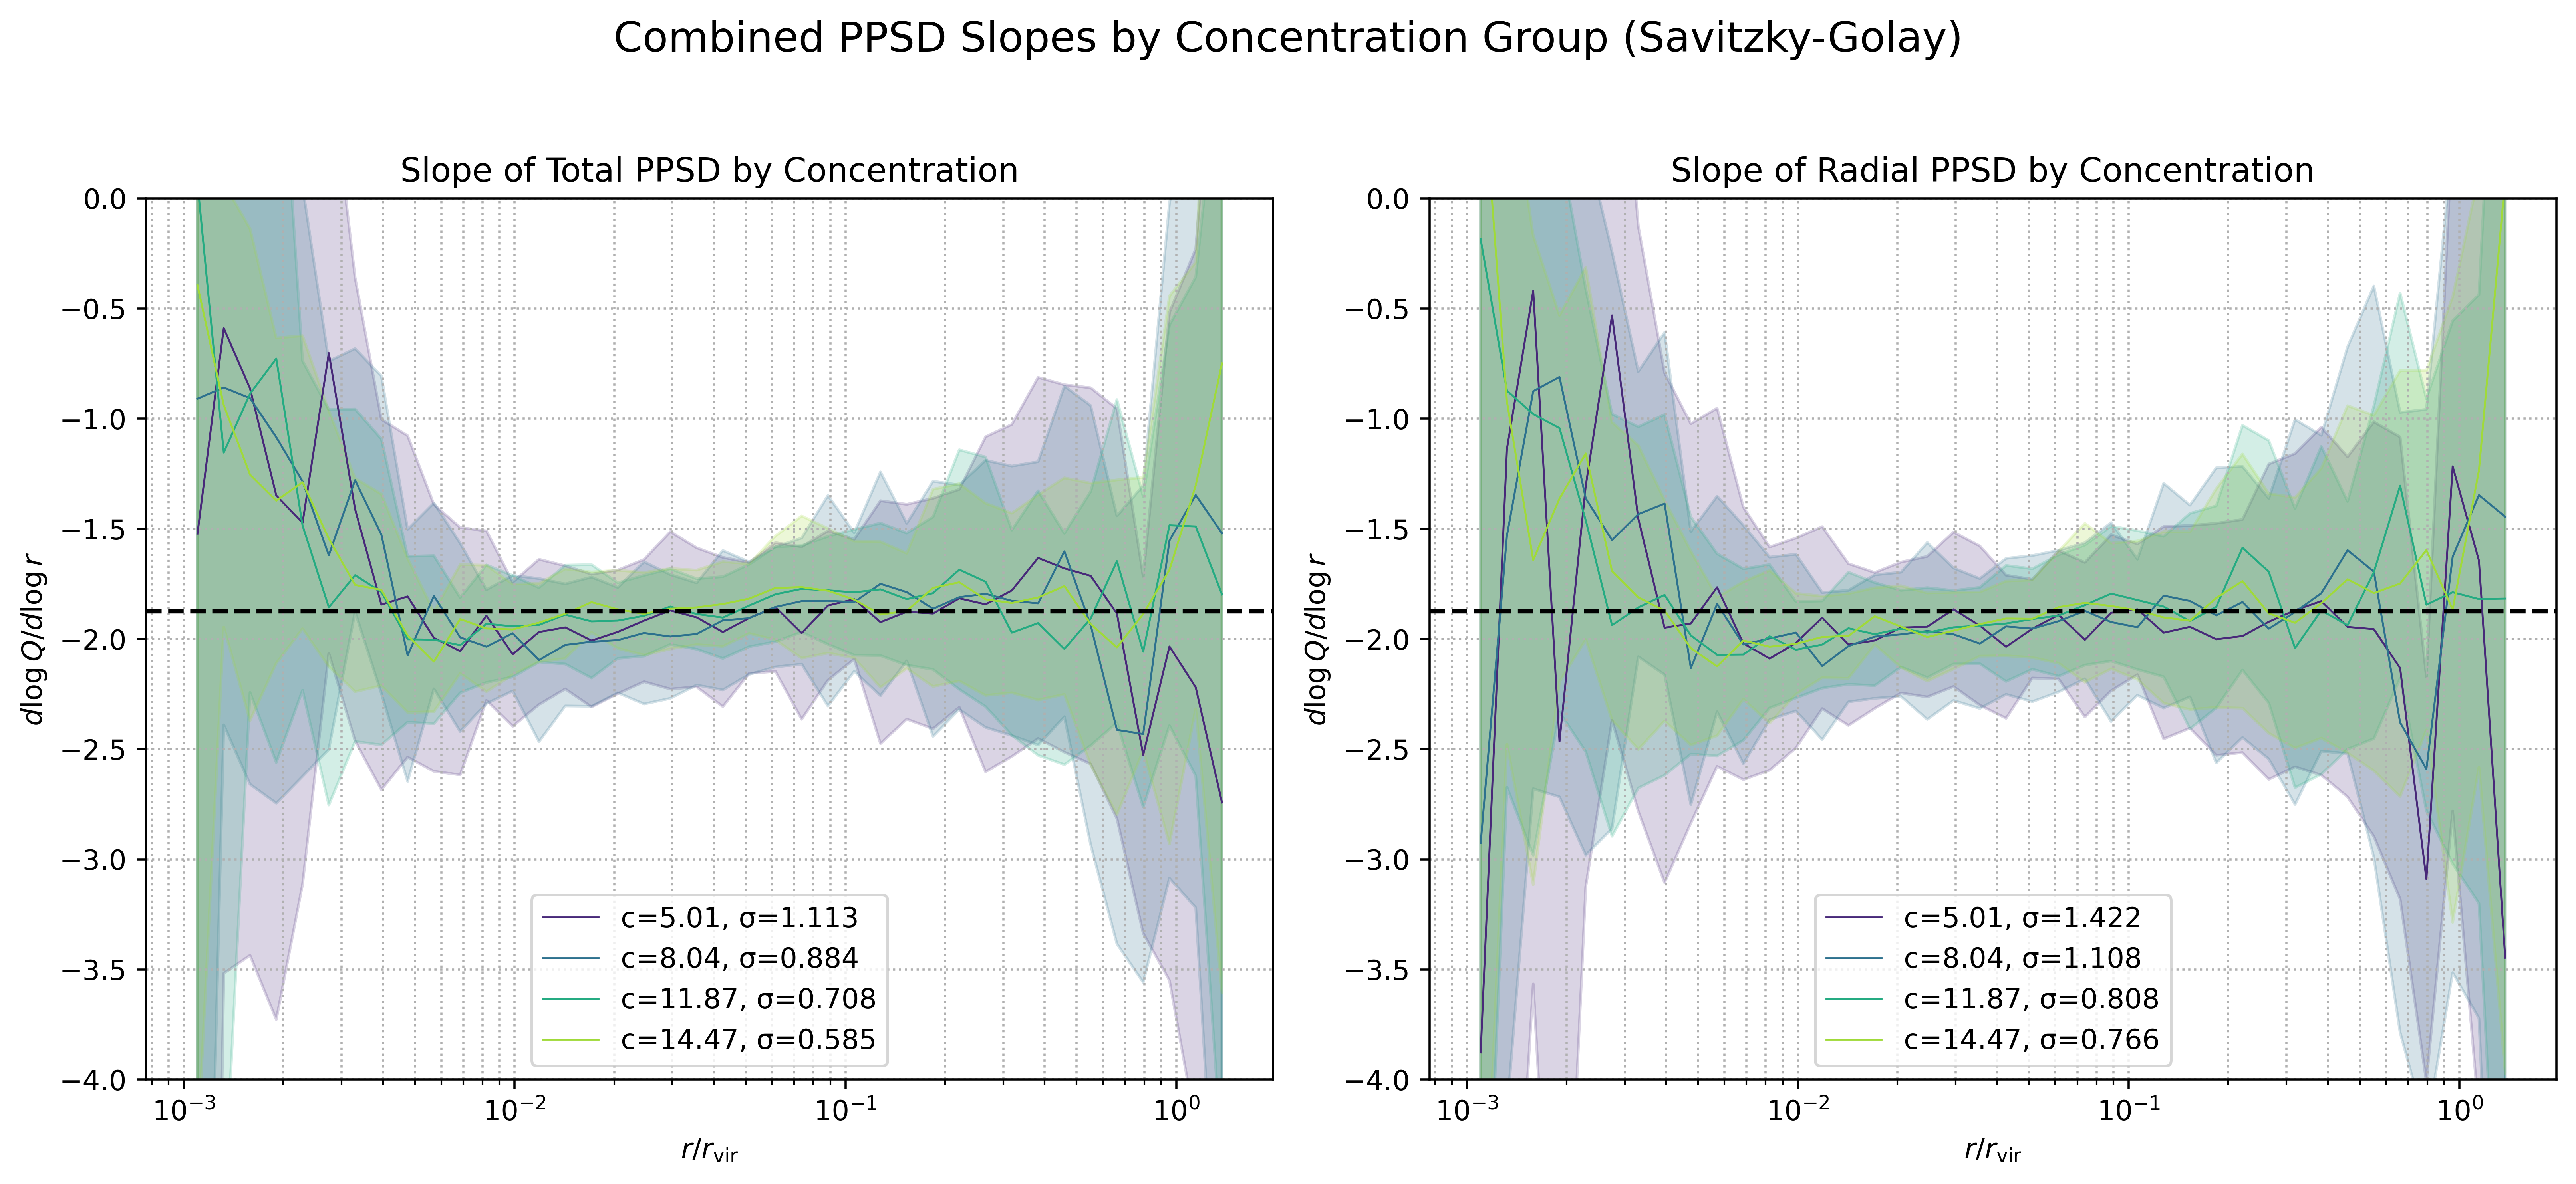

[Saved] Combined PPSD slope figure


In [99]:

def plot_combined_slopes_by_c(base_dir, suite_names,
                              window_length=5, polyorder=3):
    """
    Combine multiple suites' halos, group by concentration (c_vir) percentiles,
    compute Savitzky-Golay smoothed slopes of total and radial PPSD,
    and plot mean slopes with std shaded regions per concentration bin.
    Legend shows mean concentration and slope std per group.

    Parameters
    ----------
    base_dir : str
        Root directory containing simulation outputs.
    suite_names : list of str
        List of suite folder names to include.
    window_length : int
        Window length for Savitzky-Golay filter (must be odd).
    polyorder : int
        Polynomial order for Savitzky-Golay filter.
    """

    all_concs = []
    all_slope_tot = []
    all_slope_rad = []
    all_r = []

    # Loop over each suite
    for suite_name in suite_names:
        density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
        velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")

        density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
        velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
        n_halos = len(density_files)

        # Loop over each halo
        for i in range(n_halos):
            sim_dir = symlib.get_host_directory(base_dir, suite_name, i)
            try:
                r_data, hist = symlib.read_rockstar(sim_dir)
                host = r_data[0, -1]
                cvir = host['cvir']
            except Exception:
                continue  # Skip if data unavailable

            # Read density and velocity profiles
            df_rho = pd.read_csv(os.path.join(density_dir, density_files[i]))
            df_vel = pd.read_csv(os.path.join(velocity_dir, velocity_files[i]))

            r = df_rho["r_scaled"].values
            rho = df_rho["rho_scaled"].values
            sigma_tot = df_vel["sigma_total_scaled"].values
            sigma_rad = df_vel["sigma_rad_scaled"].values

            # Compute pseudo phase-space density Q = rho / sigma^3
            with np.errstate(divide="ignore", invalid="ignore"):
                Q_tot = np.where(sigma_tot > 0, rho / sigma_tot**3, np.nan)
                Q_rad = np.where(sigma_rad > 0, rho / sigma_rad**3, np.nan)

            log_Q_tot = np.log10(Q_tot)
            log_Q_rad = np.log10(Q_rad)
            log_r = np.log10(r)

            valid_tot = np.isfinite(log_Q_tot)
            valid_rad = np.isfinite(log_Q_rad)

            # Apply Savitzky-Golay filter to smooth and calculate slope (derivative)
            if np.sum(valid_tot) >= window_length and np.sum(valid_rad) >= window_length:
                delta_log_r = np.diff(log_r)[0]

                slope_tot = savgol_filter(log_Q_tot[valid_tot], window_length, polyorder,
                                          deriv=1, delta=delta_log_r, mode='interp')
                slope_rad = savgol_filter(log_Q_rad[valid_rad], window_length, polyorder,
                                          deriv=1, delta=delta_log_r, mode='interp')

                slope_full_tot = np.full_like(log_r, np.nan)
                slope_full_rad = np.full_like(log_r, np.nan)
                slope_full_tot[valid_tot] = slope_tot
                slope_full_rad[valid_rad] = slope_rad

                all_concs.append(cvir)
                all_slope_tot.append(slope_full_tot)
                all_slope_rad.append(slope_full_rad)
                all_r.append(r)

    all_concs = np.array(all_concs)
    all_slope_tot = np.array(all_slope_tot)
    all_slope_rad = np.array(all_slope_rad)
    all_r = np.array(all_r)

    # Define concentration bins by percentiles
    c_bins = np.percentile(all_concs, [0, 25, 50, 75, 100])
    cmap = cm.viridis
    norm = plt.Normalize(vmin=np.nanmin(all_concs), vmax=np.nanmax(all_concs))
    colors = [cmap(norm(np.mean(c_bins[i:i+2]))) for i in range(4)]

    fig, axes = plt.subplots(1, 2, figsize=(13, 6), dpi=500, sharex=True)
    ax_tot, ax_rad = axes

    # Loop over bins to plot mean slopes with shaded std
    for i in range(4):
        in_bin = (all_concs >= c_bins[i]) & (all_concs < c_bins[i+1])
        group_slope_tot = all_slope_tot[in_bin]
        group_slope_rad = all_slope_rad[in_bin]
        r_bin = all_r[in_bin]

        if len(r_bin) == 0:
            continue

        r_ref = r_bin[0]  # Assume common radius grid
        slope_tot_mean = np.nanmean(group_slope_tot, axis=0)
        slope_tot_std = np.nanstd(group_slope_tot, axis=0)
        slope_rad_mean = np.nanmean(group_slope_rad, axis=0)
        slope_rad_std = np.nanstd(group_slope_rad, axis=0)

        mean_c = np.nanmean(all_concs[in_bin])
        mean_sigma_tot = np.nanmean(slope_tot_std)
        mean_sigma_rad = np.nanmean(slope_rad_std)

        label_tot = f"c={mean_c:.2f}, σ={mean_sigma_tot:.3f}"
        label_rad = f"c={mean_c:.2f}, σ={mean_sigma_rad:.3f}"

        ax_tot.plot(r_ref, slope_tot_mean, lw=0.7, label=label_tot, color=colors[i])
        ax_tot.fill_between(r_ref, slope_tot_mean - slope_tot_std,
                            slope_tot_mean + slope_tot_std,
                            alpha=0.2, color=colors[i])

        ax_rad.plot(r_ref, slope_rad_mean, lw=0.7, label=label_rad, color=colors[i])
        ax_rad.fill_between(r_ref, slope_rad_mean - slope_rad_std,
                            slope_rad_mean + slope_rad_std,
                            alpha=0.2, color=colors[i])

    # Format axes
    for ax in axes:
        ax.axhline(-1.875, color='k', linestyle='--')
        ax.set_xscale("log")
        ax.set_ylim(-4, 0)
        ax.set_xlabel(r"$r / r_{\rm vir}$")
        ax.set_ylabel(r"$d\log Q / d\log r$")
        ax.grid(True, which="both", linestyle=":")
        ax.legend()

    ax_tot.set_title("Slope of Total PPSD by Concentration")
    ax_rad.set_title("Slope of Radial PPSD by Concentration")

    fig.suptitle("Combined PPSD Slopes by Concentration Group (Savitzky-Golay)", fontsize=15)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    output_dir = os.path.join(base_dir, "output", "combined", "figures")
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir, "PPSD_slopes_by_concentration.png"))
    plt.show()
    print("[Saved] Combined PPSD slope figure")

# Example usage:
plot_combined_slopes_by_c(
    "/Volumes/Atlas/Symphony",
    ["SymphonyMilkyWay", "SymphonyLMC", "SymphonyLCluster"]
)

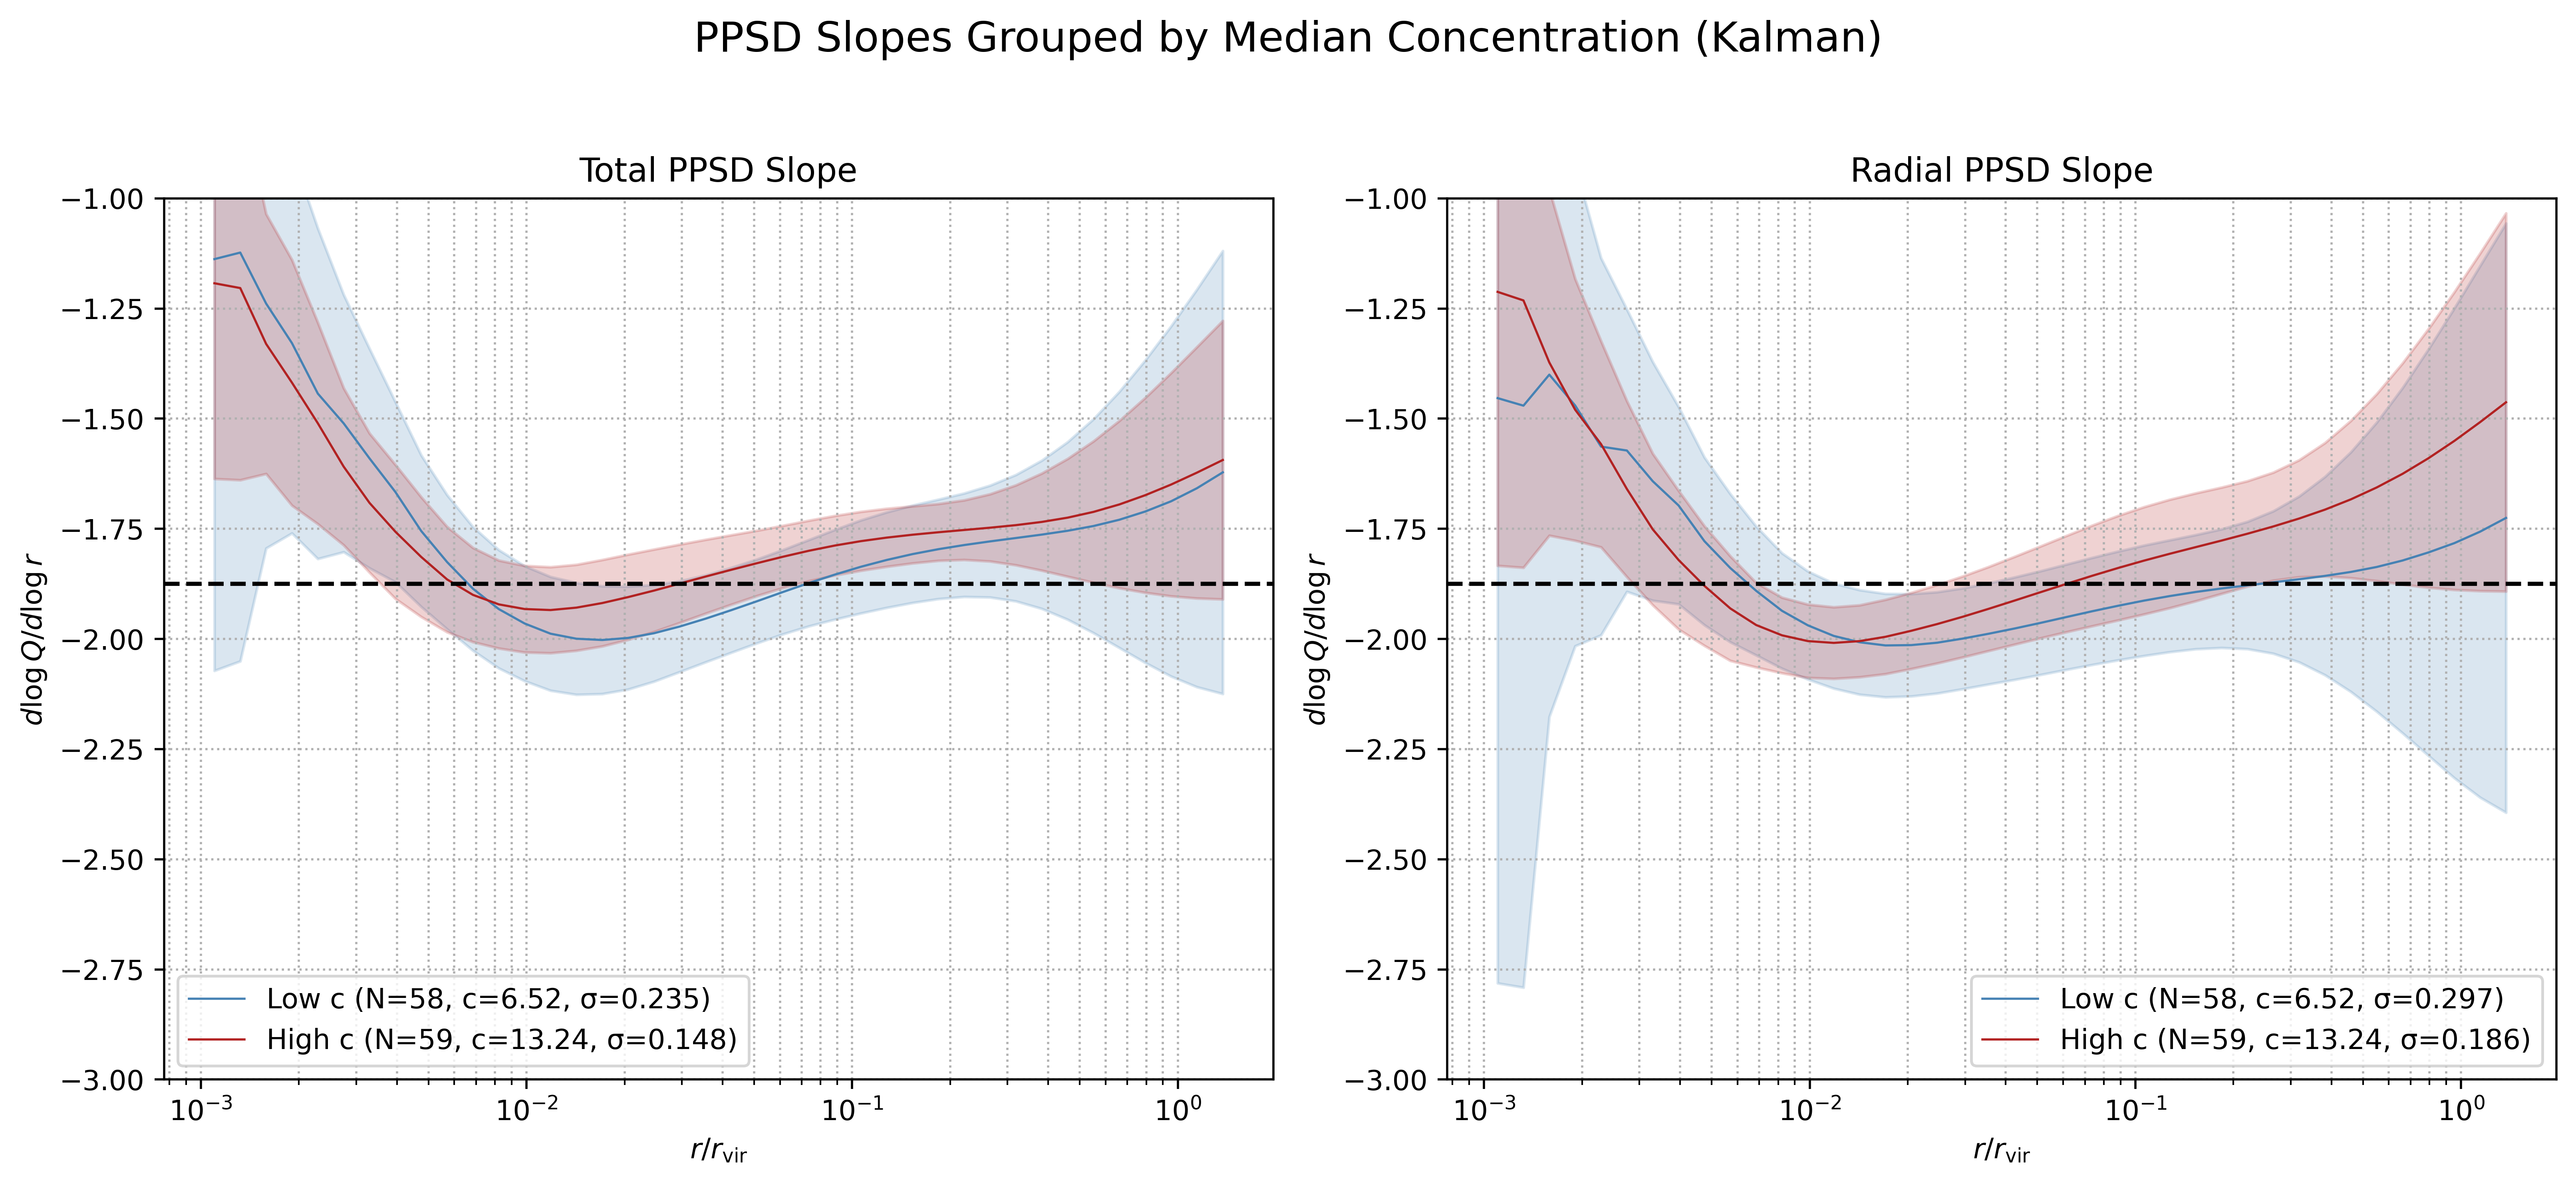

[Saved] PPSD slopes by median concentration


In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import pynumdiff
import pynumdiff.kalman_smooth
import pynumdiff.optimize.kalman_smooth
import symlib  

def plot_combined_slopes_by_c(base_dir, suite_names):
    """
    Combine multiple suites' halos, split by median concentration (c_vir),
    compute Kalman-smoothed slopes of total and radial PPSD,
    and plot mean slopes with std shaded regions for low/high-c groups.
    """
    all_concs = []
    all_slope_tot = []
    all_slope_rad = []
    all_r = []

    for suite_name in suite_names:
        density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
        velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")

        density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
        velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
        n_halos = len(density_files)

        for i in range(n_halos):
            sim_dir = symlib.get_host_directory(base_dir, suite_name, i)
            try:
                r_data, hist = symlib.read_rockstar(sim_dir)
                host = r_data[0, -1]
                cvir = host['cvir']
            except Exception:
                continue

            df_rho = pd.read_csv(os.path.join(density_dir, density_files[i]))
            df_vel = pd.read_csv(os.path.join(velocity_dir, velocity_files[i]))

            r = df_rho["r_scaled"].values
            rho = df_rho["rho_scaled"].values
            sigma_tot = df_vel["sigma_total_scaled"].values
            sigma_rad = df_vel["sigma_rad_scaled"].values

            with np.errstate(divide="ignore", invalid="ignore"):
                Q_tot = np.where(sigma_tot > 0, rho / sigma_tot**3, np.nan)
                Q_rad = np.where(sigma_rad > 0, rho / sigma_rad**3, np.nan)

            log_Q_tot = np.log10(Q_tot)
            log_Q_rad = np.log10(Q_rad)
            log_r = np.log10(r)

            valid_tot = np.isfinite(log_Q_tot)
            valid_rad = np.isfinite(log_Q_rad)

            if np.sum(valid_tot) < 5 or np.sum(valid_rad) < 5:
                continue

            try:
                dt_tot = np.mean(np.diff(log_r[valid_tot]))
                params_tot, _ = pynumdiff.optimize.kalman_smooth.constant_jerk(log_Q_tot[valid_tot], dt_tot)
                _, slope_tot = pynumdiff.kalman_smooth.constant_jerk(log_Q_tot[valid_tot], dt_tot, params_tot)

                dt_rad = np.mean(np.diff(log_r[valid_rad]))
                params_rad, _ = pynumdiff.optimize.kalman_smooth.constant_jerk(log_Q_rad[valid_rad], dt_rad)
                _, slope_rad = pynumdiff.kalman_smooth.constant_jerk(log_Q_rad[valid_rad], dt_rad, params_rad)
            except Exception:
                continue

            slope_full_tot = np.full_like(log_r, np.nan)
            slope_full_rad = np.full_like(log_r, np.nan)
            slope_full_tot[valid_tot] = slope_tot
            slope_full_rad[valid_rad] = slope_rad

            all_concs.append(cvir)
            all_slope_tot.append(slope_full_tot)
            all_slope_rad.append(slope_full_rad)
            all_r.append(r)

    # Convert to arrays
    all_concs = np.array(all_concs)
    all_slope_tot = np.array(all_slope_tot)
    all_slope_rad = np.array(all_slope_rad)
    all_r = np.array(all_r)

    # Split into above/below median concentration
    c_median = np.nanmedian(all_concs)
    groups = {
        "Low c": all_concs < c_median,
        "High c": all_concs >= c_median
    }
    colors = {
        "Low c": "steelblue",
        "High c": "firebrick"
    }

    fig, axes = plt.subplots(1, 2, figsize=(13, 6), dpi=500, sharex=True)
    ax_tot, ax_rad = axes

    for label, mask in groups.items():
        if np.sum(mask) == 0:
            continue

        r_ref = all_r[mask][0]
        slope_tot_grp = all_slope_tot[mask]
        slope_rad_grp = all_slope_rad[mask]

        slope_tot_mean = np.nanmean(slope_tot_grp, axis=0)
        slope_tot_std = np.nanstd(slope_tot_grp, axis=0)
        slope_rad_mean = np.nanmean(slope_rad_grp, axis=0)
        slope_rad_std = np.nanstd(slope_rad_grp, axis=0)

        c_mean = np.nanmean(all_concs[mask])
        sigma_tot_mean = np.nanmean(slope_tot_std)
        sigma_rad_mean = np.nanmean(slope_rad_std)
        n_halos = np.sum(mask)

        label_tot = f"{label} (N={n_halos}, c={c_mean:.2f}, σ={sigma_tot_mean:.3f})"
        label_rad = f"{label} (N={n_halos}, c={c_mean:.2f}, σ={sigma_rad_mean:.3f})"

        ax_tot.plot(r_ref, slope_tot_mean, label=label_tot, lw=0.8, color=colors[label])
        ax_rad.plot(r_ref, slope_rad_mean, label=label_rad, lw=0.8, color=colors[label])
        ax_tot.fill_between(r_ref, slope_tot_mean - slope_tot_std, slope_tot_mean + slope_tot_std,
                            color=colors[label], alpha=0.2)
        ax_rad.fill_between(r_ref, slope_rad_mean - slope_rad_std, slope_rad_mean + slope_rad_std,
                            color=colors[label], alpha=0.2)

    for ax in axes:
        ax.axhline(-1.875, color='k', linestyle='--')
        ax.set_xscale("log")
        ax.set_ylim(-3, -1)
        ax.set_xlabel(r"$r / r_{\rm vir}$")
        ax.set_ylabel(r"$d\log Q / d\log r$")
        ax.grid(True, which="both", linestyle=":")
        ax.legend()

    ax_tot.set_title("Total PPSD Slope")
    ax_rad.set_title("Radial PPSD Slope")

    fig.suptitle("PPSD Slopes Grouped by Median Concentration (Kalman)", fontsize=15)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    output_dir = os.path.join(base_dir, "output", "combined", "figures")
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir, "PPSD_slopes_by_c_median_kalman.png"))
    plt.show()
    print("[Saved] PPSD slopes by median concentration")

plot_combined_slopes_by_c(
    "/Volumes/Atlas/Symphony",
    ["SymphonyMilkyWay", "SymphonyLMC", "SymphonyLCluster"]
)

In [ ]:

def plot_entropy_slope_curves(base_dir, suite_name, window_width=0.3):
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
    assert len(density_files) == len(velocity_files), "Mismatch in number of halos."

    fig, ax = plt.subplots(figsize=(7, 5))

    # 统一的插值半径范围
    r_interp = np.logspace(-3, 0.1, 100)
    all_interp_slopes = []

    for f_rho, f_vel in zip(density_files, velocity_files):
        df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
        df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))

        r = df_rho["r_scaled"].values
        rho = df_rho["rho_scaled"].values
        sigma_tot = df_vel["sigma_total_scaled"].values

        with np.errstate(divide="ignore", invalid="ignore"):
            entropy = np.where((rho > 0) & (sigma_tot > 0),
                               sigma_tot**2 * rho**(-2/3),
                               np.nan)

        # log–log slope of entropy
        log_r = np.log10(r)
        log_k = np.log10(entropy)
        slopes = np.full_like(r, np.nan)

        for i in range(len(r)):
            log_r_i = log_r[i]
            dlogr = window_width / 2
            idx = (log_r >= log_r_i - dlogr) & (log_r <= log_r_i + dlogr)
            if np.sum(idx) >= 2:
                slope, *_ = linregress(log_r[idx], log_k[idx])
                slopes[i] = slope

        valid = (r > 0) & np.isfinite(slopes)
        if np.sum(valid) > 0:
            ax.plot(r[valid], slopes[valid], alpha=0.3, color="C1")

            try:
                interp_func = interp1d(np.log10(r[valid]), slopes[valid],
                                       kind="linear", bounds_error=False, fill_value=np.nan)
                interp_slopes = interp_func(np.log10(r_interp))
                all_interp_slopes.append(interp_slopes)
            except Exception as e:
                print(f"[Warning] Interpolation failed for one halo: {e}")

    # 计算均值和标准差
    all_interp_slopes = np.array(all_interp_slopes)
    mean_slope = np.nanmean(all_interp_slopes, axis=0)
    std_slope = np.nanstd(all_interp_slopes, axis=0)

    # 绘制平均曲线和 ±1σ 区间
    ax.plot(r_interp, mean_slope, color="C0", lw=2, label="Mean")
    ax.fill_between(r_interp, mean_slope - std_slope, mean_slope + std_slope,
                    color="C0", alpha=0.3, label=r"$\pm 1\sigma$")

    ax.set_xlabel(r"$r / r_{\mathrm{vir}}$")
    ax.set_ylabel(r"$\frac{d\log k_{\rm DM}}{d\log r}$")
    ax.set_title("DM Entropy Slope Curves")
    ax.set_xscale("log")
    ax.grid(True, which="both", linestyle=":")
    ax.axhline(1.21, color='k', linestyle='--', label="1.21")
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "entropy_slope.png"))
    plt.show()
    print("[Saved] Entropy slope figure with mean and 1σ saved.")

# Example usage
plot_entropy_slope_curves("/Volumes/Atlas/Symphony", "SymphonyLMC", window_width=0.3)